> **Setup and Config**

# **Step 1: Initial Setup**
This section includes mounting Google Drive, installing dependencies, and importing required libraries.

>> mount google drive to colab

## **1.1 Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **1.2 Install Dependencies**

>> install setup

## **1.3 Import Required Libraries**

>> import setup

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

# **Step 2: Data Preparation**
This section covers dataset loading and preprocessing.

## **2.1 Load Dataset**

> download data

In [ ]:
%%writefile kaggle.json
{"username":"sairamparshi07","key":"a07ce4e9f16b95b9b0c358f5b12deec7"}

In [ ]:
def download_kaggle_dataset(dataset_path):

    os.system('pip install -q kaggle')

    if not os.path.isfile('kaggle.json'):
        print("kaggle.json file not found. Please upload it.")
        return

    os.system('mkdir -p ~/.kaggle')
    os.system('cp kaggle.json ~/.kaggle/')
    os.system('chmod 600 ~/.kaggle/kaggle.json')

    os.system(f'kaggle datasets download -d {dataset_path}')
    zip_file = f'{dataset_path.split("/")[-1]}.zip'
    os.system(f'unzip -q {zip_file}')

download_kaggle_dataset('ahmedashrafahmed/bone-fracture')

## **2.2 Preprocess Data**

> **Data Loading**

In [ ]:
def load_data(dataset_path):
    images, labels = [], []
    for subfolder in os.listdir(dataset_path):
        subfolder_path = os.path.join(dataset_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        for image_filename in os.listdir(subfolder_path):
            if image_filename.endswith(".jpg"):
                image_path = os.path.join(subfolder_path, image_filename)
                images.append(image_path)
                labels.append(subfolder)
    return pd.DataFrame({'image': images, 'label': labels})

#paths
train_data = load_data('/content/dataset/train')
test_data = load_data('/content/dataset/test')
val_data = load_data('/content/dataset/val')

> visualize data

In [ ]:
def plot_data_distribution(data, title):
    plt.figure(figsize=(15, 5))
    sns.countplot(x=data['label'])
    plt.xlabel("Class")
    plt.ylabel("Number of Samples")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.grid(True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plot_data_distribution(train_data, 'Train Data Distribution')

In [ ]:
plot_data_distribution(test_data, 'Test Data Distribution')

In [ ]:
plot_data_distribution(val_data, 'Validation Data Distribution')

> display sample images

In [ ]:
def display_sample_images(data, num_samples=10):
    plt.figure(figsize=(50, 50))
    for i, idx in enumerate(np.random.randint(0, len(data), num_samples)):
        plt.subplot(10, 5, i + 1)
        img = cv2.imread(data.iloc[idx]['image'])
        plt.imshow(img)
        plt.axis('off')
        plt.title(data.iloc[idx]['label'], fontsize=25)

# Display sample images from training set
display_sample_images(train_data, 50)

> data augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # ✅ Correct Import

# Image data generation/augmentation
image_size = (224, 224)
batch_size = 32
datagen = ImageDataGenerator(rescale=1./255)

# Creating generators for train, test, and validation sets
train_generator = datagen.flow_from_dataframe(
    train_data, x_col='image', y_col='label', target_size=image_size,
    batch_size=batch_size, class_mode='binary', shuffle=True
)
test_generator = datagen.flow_from_dataframe(
    test_data, x_col='image', y_col='label', target_size=image_size,
    batch_size=batch_size, class_mode='binary', shuffle=False
)
val_generator = datagen.flow_from_dataframe(
    val_data, x_col='image', y_col='label', target_size=image_size,
    batch_size=batch_size, class_mode='binary', shuffle=True
)

Found 4097 validated image filenames belonging to 2 classes.
Found 399 validated image filenames belonging to 2 classes.
Found 404 validated image filenames belonging to 2 classes.


# **Step 3: Model Development**
Here, we define, train, and evaluate the deep learning model.

> Modeling

In [ ]:
class_num=1
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3),activation=tf.nn.relu,input_shape=(224,224,3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2,2)))
model.add(keras.layers.Conv2D(filters=64, kernel_size=(3,3),activation=tf.nn.relu))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2,2)))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Conv2D(filters=128, kernel_size=(3,3),activation=tf.nn.relu))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2,2)))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256,activation=tf.nn.relu))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Dense(128,activation=tf.nn.relu))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Dense(class_num,activation=tf.nn.sigmoid))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,278,593 (84.99 MB)

 Trainable params: 22,278,145 (84.98 MB)

 Non-trainable params: 448 (1.75 KB)

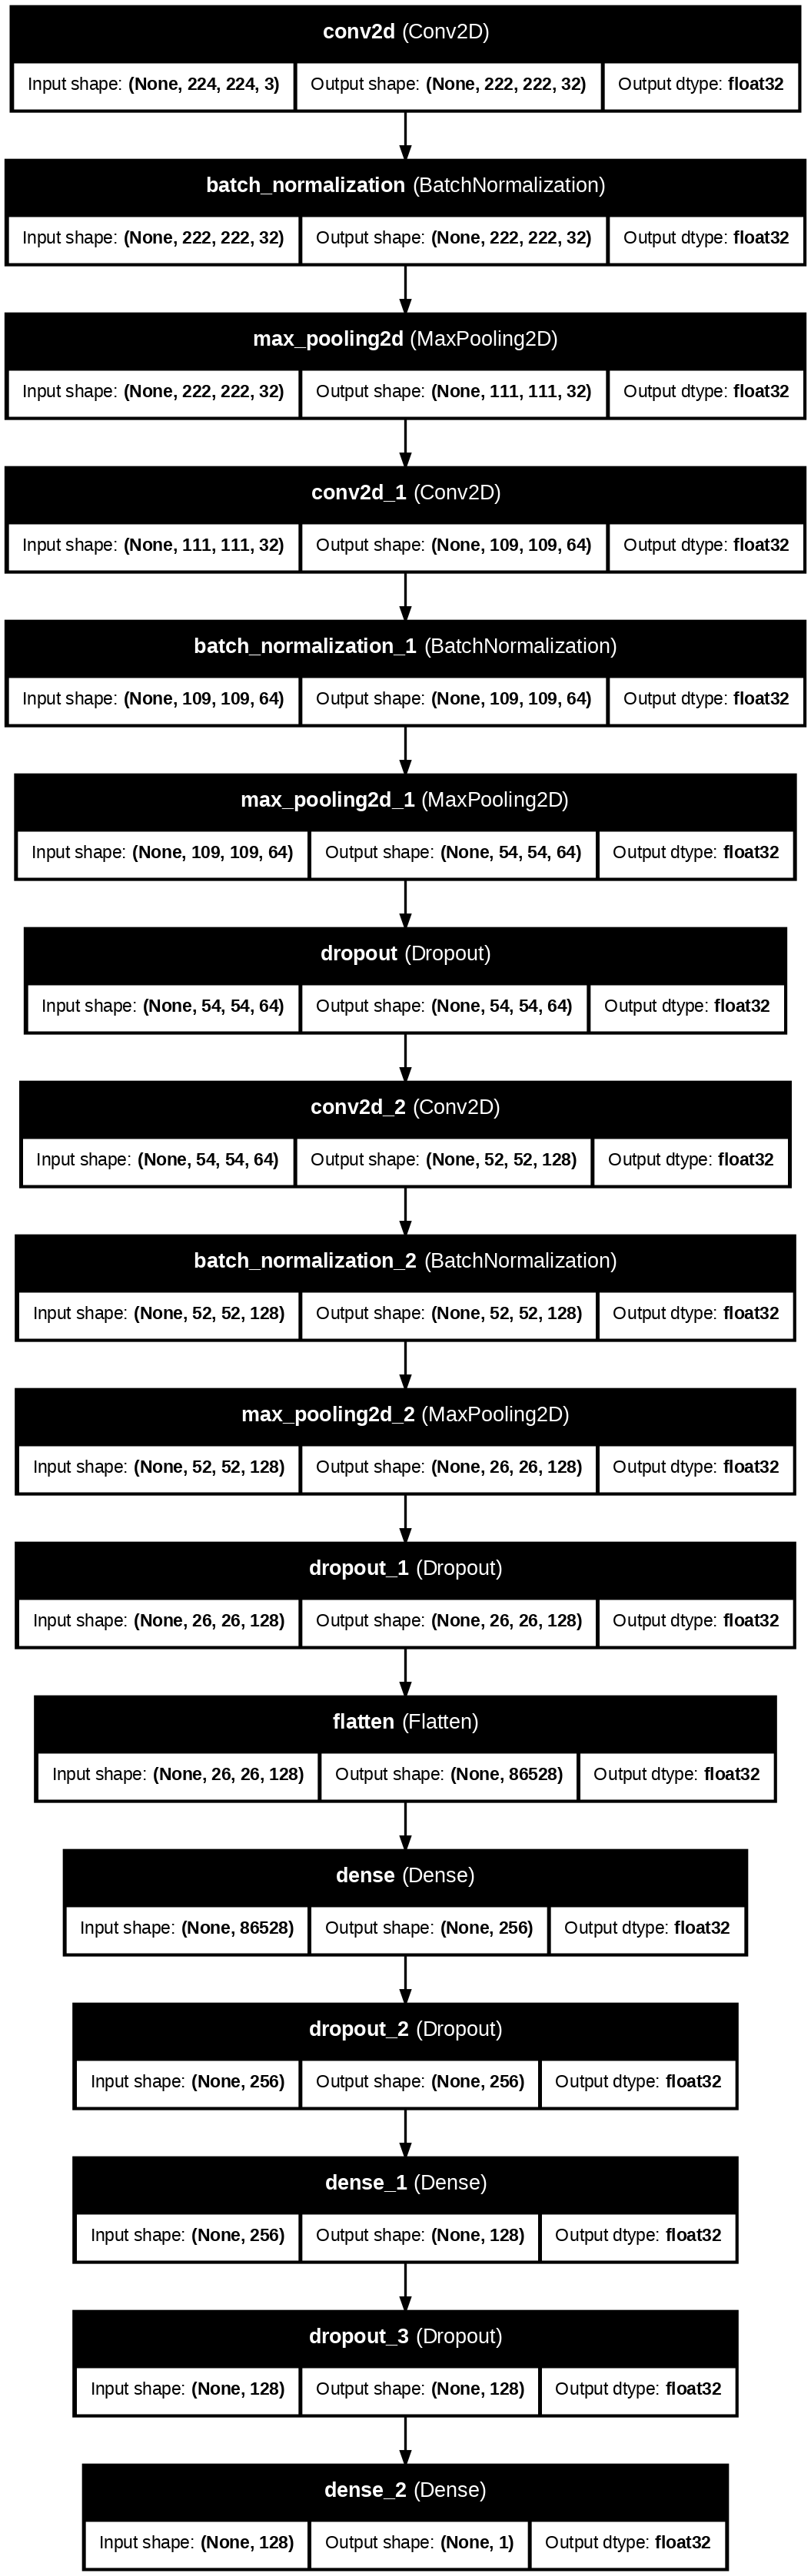

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

# **Step 4: Model Deployment**
Finally, we export and deploy the model on Hugging Face.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
from tensorflow import keras

# Define callbacks
checkpoint_cb = ModelCheckpoint("my_keras_model.h5", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)

# Compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.SpecificityAtSensitivity(0.5),
        keras.metrics.AUC()
    ]
)

# Train model (use fit instead of fit_generator)
hist = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.6606 - auc_1: 0.6950 - loss: 4.8329 - specificity_at_sensitivity_1: 0.7646

129/129 ━━━━━━━━━━━━━━━━━━━━ 48s 232ms/step - accuracy: 0.6611 - auc_1: 0.6955 - loss: 4.8189 - specificity_at_sensitivity_1: 0.7651 - val_accuracy: 0.5792 - val_auc_1: 0.6308 - val_loss: 1.6123 - val_specificity_at_sensitivity_1: 0.6429
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.7955 - auc_1: 0.8620 - loss: 0.9319 - specificity_at_sensitivity_1: 0.9174 - val_accuracy: 0.5842 - val_auc_1: 0.5000 - val_loss: 11.8613 - val_specificity_at_sensitivity_1: 0.0000e+00
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 71ms/step - accuracy: 0.8573 - auc_1: 0.9311 - loss: 0.4042 - specificity_at_sensitivity_1: 0.9813 - val_accuracy: 0.6262 - val_auc_1: 0.5972 - val_loss: 7.3439 - val_specificity_at_sensitivity_1: 0.2024
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.9103 - auc_1: 0.9689 - loss: 0.2485 - specificity_at_sensitivity_1: 0.9944 - val_accuracy: 0.7574 - val_auc_1: 0.7579 - val_loss: 2.3152 - val_specificity_at_sensitivity_1: 0.5595
Epoch 5/10
12

129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - accuracy: 0.9158 - auc_1: 0.9708 - loss: 0.2400 - specificity_at_sensitivity_1: 0.9938 - val_accuracy: 0.8094 - val_auc_1: 0.9753 - val_loss: 0.5767 - val_specificity_at_sensitivity_1: 1.0000
Epoch 6/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9444 - auc_1: 0.9852 - loss: 0.1626 - specificity_at_sensitivity_1: 0.9930

129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.9443 - auc_1: 0.9851 - loss: 0.1628 - specificity_at_sensitivity_1: 0.9930 - val_accuracy: 0.9752 - val_auc_1: 0.9970 - val_loss: 0.0655 - val_specificity_at_sensitivity_1: 1.0000
Epoch 7/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.9342 - auc_1: 0.9772 - loss: 0.2109 - specificity_at_sensitivity_1: 0.9910 - val_accuracy: 0.9802 - val_auc_1: 0.9975 - val_loss: 0.0664 - val_specificity_at_sensitivity_1: 1.0000
Epoch 8/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.9522 - auc_1: 0.9877 - loss: 0.1478 - specificity_at_sensitivity_1: 0.9968 - val_accuracy: 0.9728 - val_auc_1: 0.9907 - val_loss: 0.1720 - val_specificity_at_sensitivity_1: 1.0000
Epoch 9/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.9471 - auc_1: 0.9839 - loss: 0.1982 - specificity_at_sensitivity_1: 0.9918 - val_accuracy: 0.7847 - val_auc_1: 0.9094 - val_loss: 1.4199 - val_specificity_at_sensitivity_1: 1.0000
Epoch 10/10
129/129 ━

129/129 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - accuracy: 0.9548 - auc_1: 0.9893 - loss: 0.1307 - specificity_at_sensitivity_1: 0.9974 - val_accuracy: 0.9728 - val_auc_1: 0.9985 - val_loss: 0.0623 - val_specificity_at_sensitivity_1: 1.0000


## **4.1 Export Model**

In [ ]:
import pandas as pd

# Convert training history to DataFrame
hist_ = pd.DataFrame(hist.history)

# Display DataFrame
hist_

accuracy     auc_1      loss  specificity_at_sensitivity_1  val_accuracy  \
0  0.719795  0.761882  3.010461                      0.832531      0.579208   
1  0.807664  0.881761  0.716602                      0.936959      0.584158   
2  0.870637  0.942614  0.371275                      0.986044      0.626238   
3  0.905297  0.967491  0.253007                      0.993263      0.757426   
4  0.919453  0.973598  0.227591                      0.993263      0.809406   
5  0.937515  0.981599  0.192234                      0.992300      0.975248   
6  0.937027  0.980410  0.190972                      0.993263      0.980198   
7  0.952404  0.986507  0.150328                      0.994706      0.972772   
8  0.946058  0.985643  0.168320                      0.994225      0.784653   
9  0.952892  0.987852  0.142592                      0.997113      0.972772   

   val_auc_1   val_loss  val_specificity_at_sensitivity_1  
0   0.630751   1.612340                          0.642857  
1   0.500000  11.861281                          0.000000  
2   0.597231   7.343899                          0.202381  
3   0.757869   2.315174                          0.559524  
4   0.975270   0.576701                          1.000000  
5   0.996986   0.065478                          1.000000  
6   0.997478   0.066363                          1.000000  
7   0.990681   0.171976                          1.000000  
8   0.909403   1.419912                          1.000000  
9   0.998537   0.062316                          1.000000

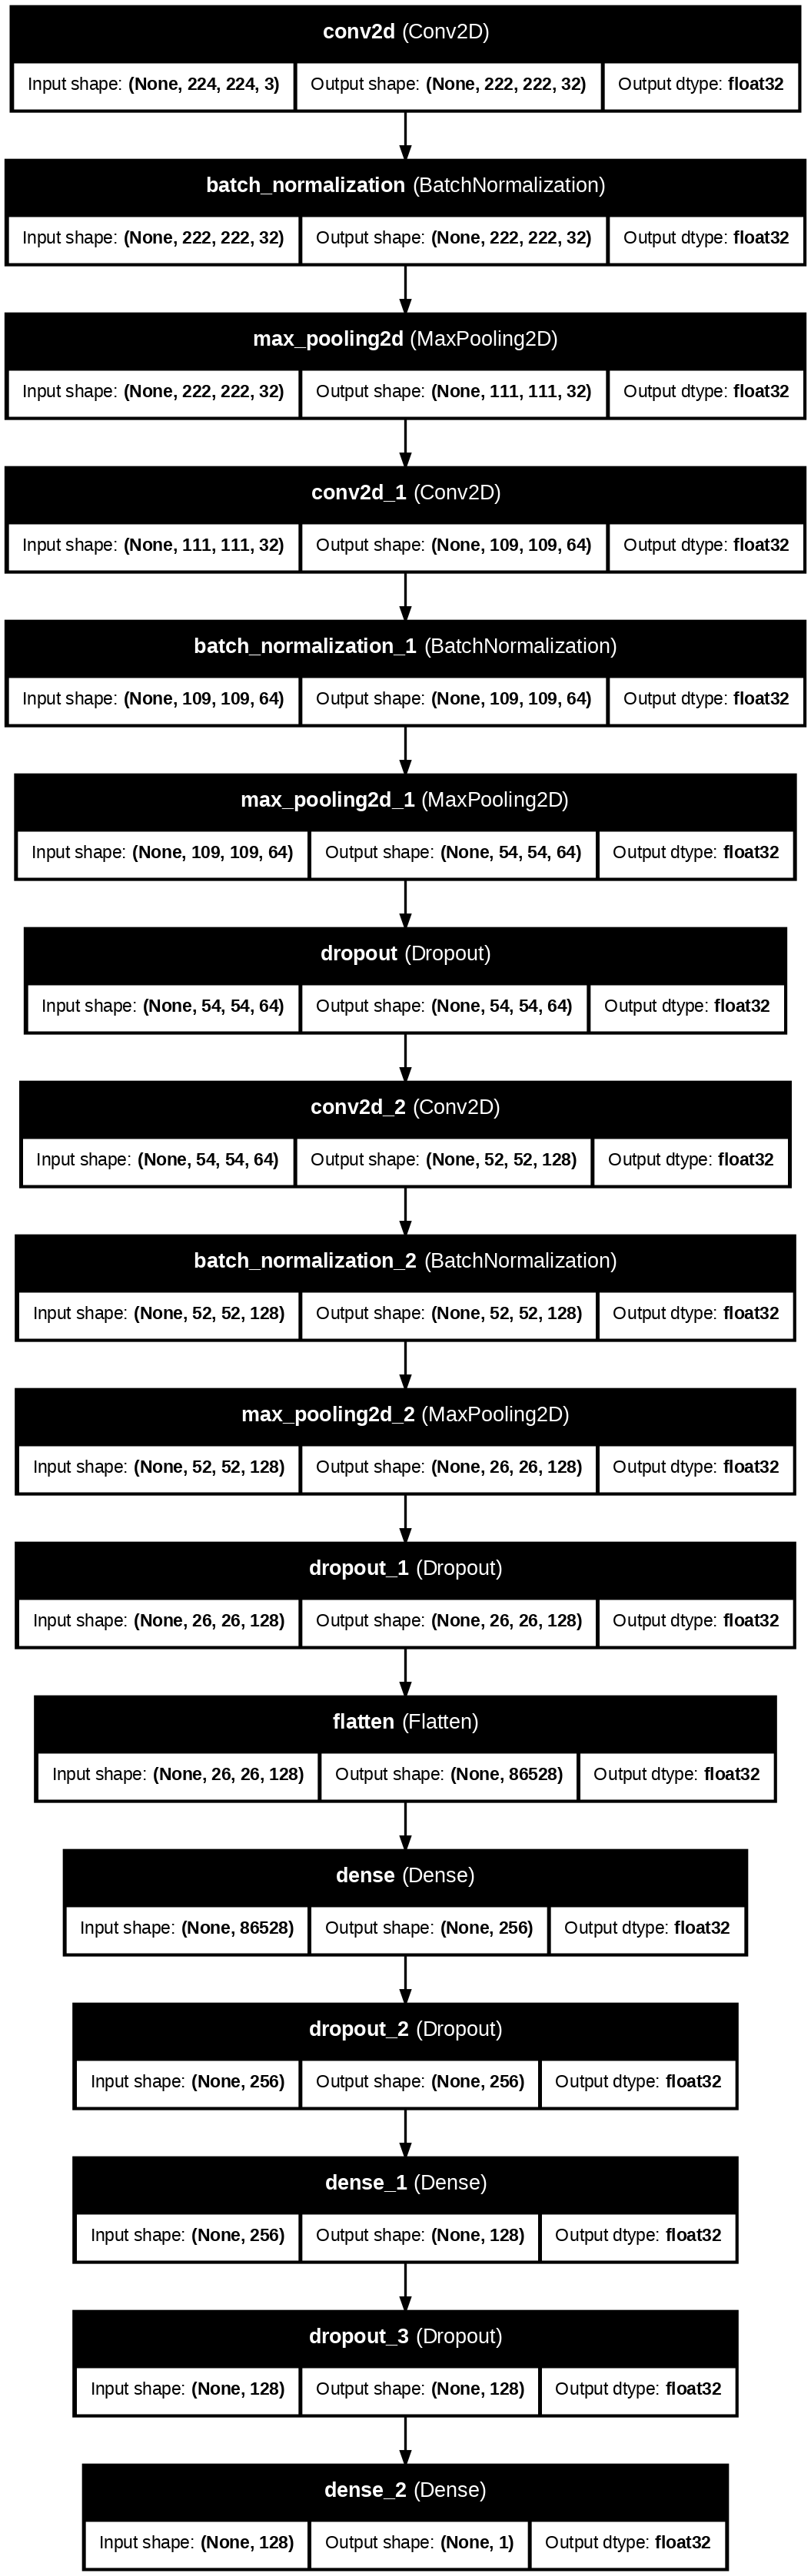

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

# Evaluation and Visualization of Model Performance


## **4.2 Deploy on Hugging Face**

In [ ]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Plotting Training History
def plot_training_history(hist):
    plt.figure(figsize=(15, 10))

    # Subplot for Loss
    plt.subplot(2, 2, 1)
    plt.plot(hist['loss'], 'b-o', label='Train Loss')
    plt.plot(hist['val_loss'], 'r-o', label='Validation Loss')
    plt.title('Train & Validation Loss', fontsize=20)
    plt.legend()

    # Subplot for Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(hist['accuracy'], 'b-o', label='Train Accuracy')
    plt.plot(hist['val_accuracy'], 'r-o', label='Validation Accuracy')
    plt.title('Train & Validation Accuracy', fontsize=20)
    plt.legend()

    # Subplot for Specificity at Sensitivity (Check if exists)
    if 'specificity_at_sensitivity_1' in hist.columns:
        plt.subplot(2, 2, 3)
        plt.plot(hist['specificity_at_sensitivity_1'], 'b-o', label='Train Specificity at Sensitivity')
        plt.plot(hist['val_specificity_at_sensitivity_1'], 'r-o', label='Validation Specificity at Sensitivity')
        plt.title('Train & Validation Specificity at Sensitivity', fontsize=20)
        plt.legend()

    # Subplot for AUC (Check if exists)
    if 'auc_1' in hist.columns:
        plt.subplot(2, 2, 4)
        plt.plot(hist['auc_1'], 'b-o', label='Train AUC')
        plt.plot(hist['val_auc_1'], 'r-o', label='Validation AUC')
        plt.title('Train & Validation AUC', fontsize=20)
        plt.legend()

    plt.show()

# Evaluating Model Performance
def evaluate_model(model, test_generator):
    # Evaluate model
    results = model.evaluate(test_generator)

    # Print results dynamically
    metric_names = model.metrics_names  # Get metric names
    for name, value in zip(metric_names, results):
        print(f"Test {name} = {value}")

# Generating Confusion Matrix and Classification Report
def generate_reports(y_test, y_pred):
    # Confusion Matrix
    CM = confusion_matrix(y_test, y_pred)
    sns.heatmap(CM, fmt='g', center=True, cbar=False, annot=True, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Classification Report
    print('Classification Report:')
    print(classification_report(y_test, y_pred))

# Displaying Predictions on Test Images
def display_test_predictions(test_generator, model):
    class_names = ['Fractured', 'Not Fractured']
    batch = next(test_generator)
    images = batch[0]

    # Get predictions
    predictions = model.predict(images)
    predicted_classes = (predictions > 0.5).astype(int).flatten()

    plt.figure(figsize=(20, 20))
    for n in range(min(len(images), 16)):  # Show up to 16 images
        plt.subplot(4, 4, n + 1)
        plt.imshow(images[n])
        plt.axis('off')
        plt.title(f"Pred: {class_names[predicted_classes[n]]}", fontsize=12)
    plt.show()

In [ ]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Plotting Training History
def plot_training_history(hist):
    plt.figure(figsize=(15, 10))

    # Subplot for Loss
    plt.subplot(2, 2, 1)
    plt.plot(hist['loss'], 'b-o', label='Train Loss')
    plt.plot(hist['val_loss'], 'r-o', label='Validation Loss')
    plt.title('Train & Validation Loss', fontsize=20)
    plt.legend()

    # Subplot for Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(hist['accuracy'], 'b-o', label='Train Accuracy')
    plt.plot(hist['val_accuracy'], 'r-o', label='Validation Accuracy')
    plt.title('Train & Validation Accuracy', fontsize=20)
    plt.legend()

    # Subplot for Sensitivity
    plt.subplot(2, 2, 3)
    plt.plot(hist['specificity_at_sensitivity'], 'b-o', label='Train Specificity at Sensitivity')
    plt.plot(hist['val_specificity_at_sensitivity'], 'r-o', label='Validation Specificity at Sensitivity')
    plt.title('Train & Validation Sensitivity', fontsize=20)
    plt.legend()

    # Subplot for AUC
    plt.subplot(2, 2, 4)
    plt.plot(hist['auc'], 'b-o', label='Train AUC')
    plt.plot(hist['val_auc'], 'r-o', label='Validation AUC')
    plt.title('Train & Validation AUC', fontsize=20)
    plt.legend()

    plt.show()

# Evaluating Model Performance
def evaluate_model(model, test_generator):
    score, acc, sensitivity, auc = model.evaluate(test_generator)
    print('Test Loss =', score)
    print('Test Accuracy =', acc)
    print('Test Sensitivity =', sensitivity)
    print('Test AUC =', auc)

# Generating Confusion Matrix and Classification Report
def generate_reports(y_test, y_pred):
    # Confusion Matrix
    CM = confusion_matrix(y_test, y_pred)
    sns.heatmap(CM, fmt='g', center=True, cbar=False, annot=True, cmap='Blues')
    plt.show()

    # Classification Report
    ClassificationReport = classification_report(y_test, y_pred)
    print('Classification Report is : ', ClassificationReport)

# Displaying Predictions on Test Images
def display_test_predictions(test_generator, model, y_test):
    class_names = ['Fractured', 'Not Fractured']
    batch = next(test_generator)
    images = batch[0]

    plt.figure(figsize=(50, 50))
    for n in range(32):
        plt.subplot(8, 4, n + 1)
        plt.imshow(images[n])
        plt.axis('off')
        plt.title(class_names[int(y_test[n])], fontsize=25)

In [ ]:
print(hist_.columns)  # Check available metric names

Index(['accuracy', 'auc_1', 'loss', 'specificity_at_sensitivity_1',
       'val_accuracy', 'val_auc_1', 'val_loss',
       'val_specificity_at_sensitivity_1'],
      dtype='object')


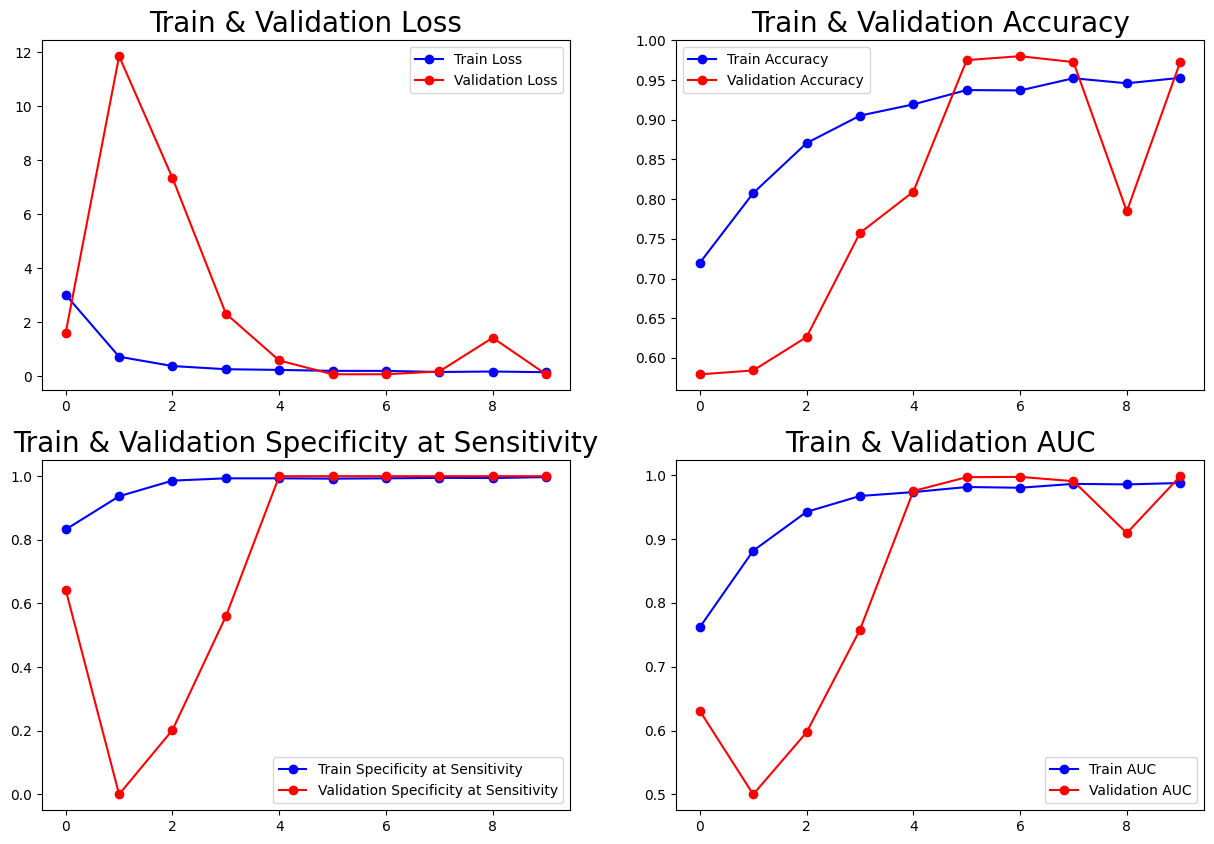

In [ ]:
import matplotlib.pyplot as plt

# Enable interactive mode to display plots instantly
plt.ion()

# Check if `hist_` is not empty before plotting
if not hist_.empty:
    plot_training_history(hist_)
else:
    print("Warning: Training history (hist_) is empty. Nothing to plot.")

# Disable interactive mode after plotting
plt.ioff()

# Suppress unwanted output by explicitly displaying an empty print
print("")

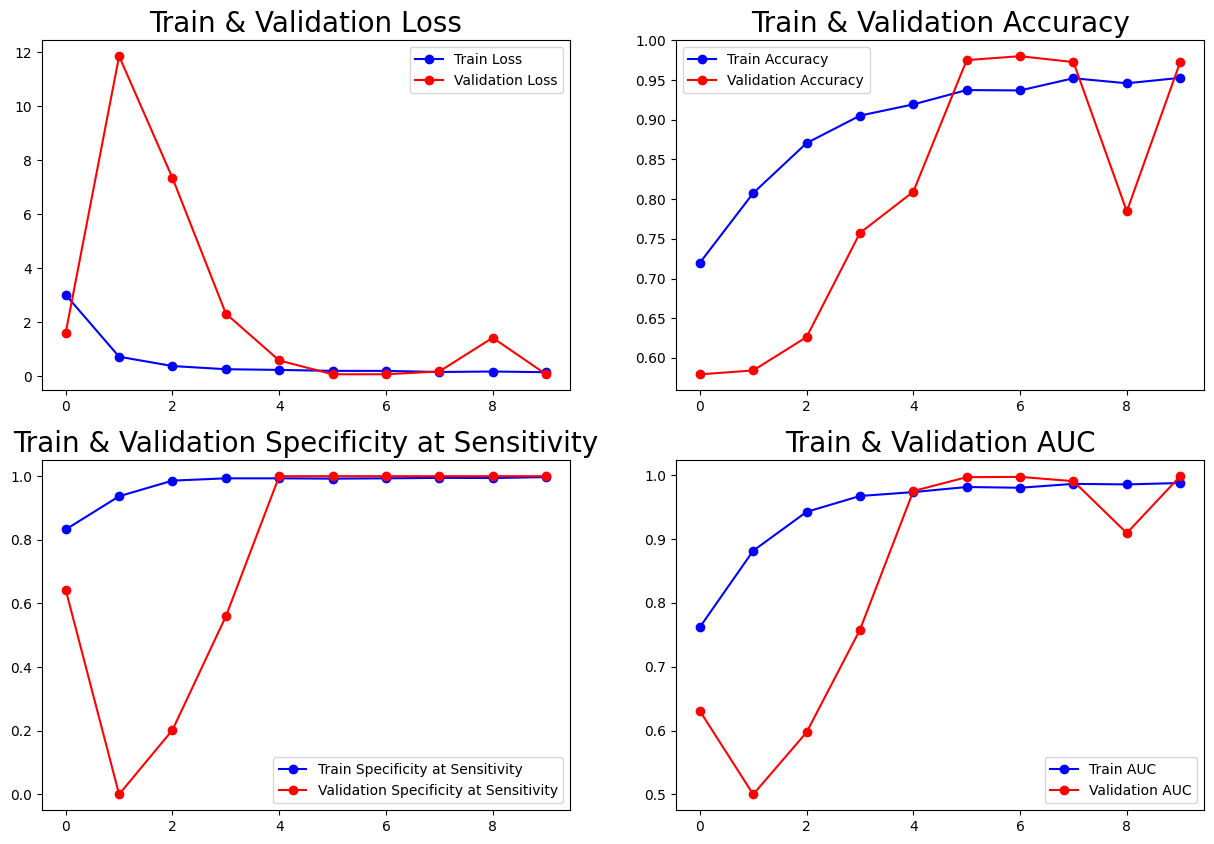

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9686 - auc_1: 0.5696 - loss: 0.0586 - specificity_at_sensitivity_1: 0.5714
Test loss = 0.10880617797374725
Test compile_metrics = 0.9624060392379761


In [ ]:
plot_training_history(hist_)

# Assuming test_generator, model, y_test, and y_pred are defined
evaluate_model(model, test_generator)

In [ ]:
y_test =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.where(predictions >= 0.5, 1, 0)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step


Actual  Prediction
0         0           0
1         0           0
2         0           0
3         0           0
4         0           0
..      ...         ...
394       1           1
395       1           1
396       1           1
397       1           1
398       1           1

[399 rows x 2 columns]

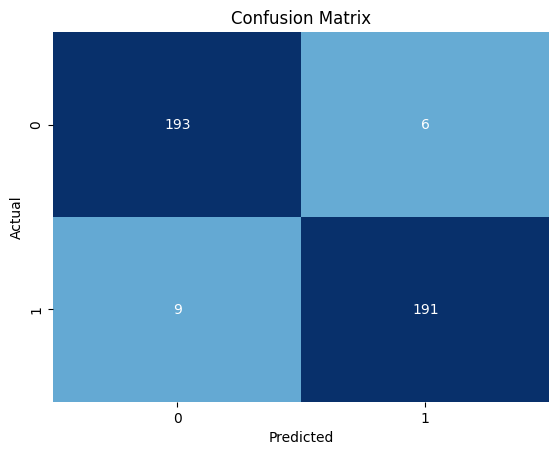

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       199
           1       0.97      0.95      0.96       200

    accuracy                           0.96       399
   macro avg       0.96      0.96      0.96       399
weighted avg       0.96      0.96      0.96       399



In [ ]:
generate_reports(y_test, y_pred)

In [ ]:
def display_test_predictions(test_generator, model, y_test):
    class_names = ['Fractured', 'Not Fractured']
    batch = next(test_generator)
    images = batch[0]

    plt.figure(figsize=(50, 50))
    for n in range(len(images)):  # Adjust loop range to avoid index errors
        plt.subplot(8, 4, n + 1)
        plt.imshow(images[n])
        plt.axis('off')
        plt.title(class_names[int(y_test[n])], fontsize=25)  # Ensure y_test is correctly formatted

In [ ]:
display_test_predictions(test_generator, model, y_test)

> **Usage**

In [ ]:
from keras.preprocessing import image
from IPython.display import display
import PIL.Image as PilImage
import numpy as np

def load_and_predict_image(model, image_path=None):
    """
    Loads an image from the given path (or using file upload if no path is provided),
    preprocesses it, and uses the model to predict whether the image shows a bone fracture.

    Args:
    model: The trained keras model.
    image_path: Path to the image file (optional).

    Returns:
    Prediction and probability.
    """
    if image_path is None:
        from google.colab import files
        uploaded = files.upload()
        image_path = list(uploaded.keys())[0]

    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create a batch
    img_array /= 255.0  # Rescale the image

    # Predict
    predictions = model.predict(img_array)
    predicted_class = 'Not Fractured' if predictions[0][0] >= 0.5 else 'Fractured'
    probability = predictions[0][0] if predictions[0][0] >= 0.5 else 1 - predictions[0][0]

    # Display the image
    display(PilImage.open(image_path))
    print(f"Prediction: {predicted_class}")
    print(f"Probability: {probability:.2f}")

Random Image Path: /content/dataset/val/fractured/7-rotated2-rotated1.jpg from fractured directory


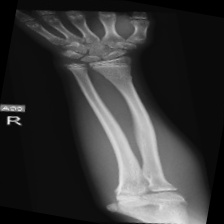

In [ ]:
import os
import random
from IPython.display import Image

def get_random_image_from_subdirectories(parent_directory):
    """
    Selects a random image from a randomly chosen subdirectory within the parent directory.

    Args:
    parent_directory: The path to the parent directory containing subdirectories.

    Returns:
    The path to the randomly selected image, and the subdirectory name.
    """
    if not os.path.isdir(parent_directory):
        print("Parent directory does not exist.")
        return None, None

    subdirectories = [d for d in os.listdir(parent_directory) if os.path.isdir(os.path.join(parent_directory, d))]
    if not subdirectories:
        print("No subdirectories found.")
        return None, None

    selected_subdir = random.choice(subdirectories)
    subdir_path = os.path.join(parent_directory, selected_subdir)

    images = [img for img in os.listdir(subdir_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not images:
        print(f"No images found in {selected_subdir} directory.")
        return None, None

    random_image = random.choice(images)
    image_path = os.path.join(subdir_path, random_image)

    return image_path, selected_subdir

# Example usage
parent_directory = '/content/dataset/val'
random_image_path, subdirectory = get_random_image_from_subdirectories(parent_directory)
if random_image_path:
    print(f"Random Image Path: {random_image_path} from {subdirectory} directory")
    display(Image(filename=random_image_path))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


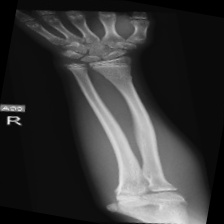

Prediction: Fractured
Probability: 1.00


In [ ]:
load_and_predict_image(model, random_image_path)  # Use this if you have an image path

> **model deploy using gradio**

In [ ]:
!pip install gradio tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.0/322.0 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 2.7 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import gradio as gr
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

In [ ]:
model = tf.keras.models.load_model("/content/my_keras_model.h5")
image_size = (224, 224)  # Update this if your model uses a different input size

In [ ]:
def predict_image(img):
    img = img.resize(image_size)  # Resize image to model's expected size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize
    prediction = model.predict(img_array)

    # Assuming binary classification (fractured or normal)
    class_names = ['Fractured', 'Normal']
    predicted_class = class_names[int(prediction[0] > 0.5)]  # Threshold at 0.5

    return f"Prediction: {predicted_class} (Confidence: {prediction[0][0]:.2f})"

interface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil"),
    outputs=gr.Textbox(),
    title="Bone Fracture Detection",
    description="i am sahil from tyds class this is my project name bone fracture detection using deep learing i deployed my model using colab on gradio which allow 72 hours free active server "
)

In [ ]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d0a67906ed4ef75831.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
